# Simulate the Hallermann et al neuron and save the parameters

In [1]:
# info: final part of axon[0]: -8.10, -69.90
# 1st NoR: -3.18, -182
# 2nd Nor: -3.9210023880004883, -216.50196838378906
# 3rd NoR: -15.484574317932129, -278.20172119140625,
# -30.89134407043457, -357.91412353515625
# -45.29114532470703, -441.8159484863281,
# -54.57005310058594, -495.56158447265625
# -62.990203857421875, -555.0670166015625
# -75.53981018066406, -634.2572021484375
# -85.00654602050781, -689.8948364257812
# -95.06448364257812, -735.9205932617188





import numpy as np
import os.path
import sys

%cd data/HallermannEtAl2012

sys.path.append('../../libs/neuroneap/') #('../../libs/')
sys.path.append('../../mylibs')

import matplotlib.pylab as plt
#import mylibs.plot_supp as pls
ext = '.pdf'
%matplotlib inline

/home/maria/maja/code/mf_full_morpho/data/HallermannEtAl2012


In [2]:
%ls /libs/neuroneap/


ls: cannot access /libs/neuroneap/: No such file or directory


In [3]:
%cat ../../libs/neuroneap/eap/__init__.py

import field
import graph


In [4]:
from eap import field, cell, graph

In [5]:
print sys.path

['', '/home/maria/anaconda2/lib/python27.zip', '/home/maria/anaconda2/lib/python2.7', '/home/maria/anaconda2/lib/python2.7/plat-linux2', '/home/maria/anaconda2/lib/python2.7/lib-tk', '/home/maria/anaconda2/lib/python2.7/lib-old', '/home/maria/anaconda2/lib/python2.7/lib-dynload', '/home/maria/anaconda2/lib/python2.7/site-packages', '/home/maria/anaconda2/lib/python2.7/site-packages/Sphinx-1.4.6-py2.7.egg', '/home/maria/maja/code/neuroneap', '/home/maria/anaconda2/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/home/maria/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/maria/.ipython', '../../libs/neuroneap/', '../../mylibs']


In [6]:
# LFP


In [7]:
# compile neuron channels (leave this in the notebook!)
#!nrnivmodl 

In [8]:
from neuron import h

In [9]:
# params
dt = 0.0125 # #0.0125 #0.001
sim_len = 60 # ms
stim_delay = 40
postfix = '' #'passive' '_noAIS' '_noAIS_noNode' # '_noAIS2' '' #Make sure to also change the postfix in the file below!
det = True

In [10]:
%%file mostest.hoc
//load_file("nrngui.hoc")
xopen("$(NEURONHOME)/lib/hoc/noload.hoc")
//load_proc("nrnmainmenu")

xopen("28_04_10_num19.hoc")

xopen("Cell parameters.hoc")
//xopen("Cell parameters_noAIS_noNode.hoc")
//xopen("Cell parameters_noAIS.hoc")
//xopen("Cell parameters_noAIS2.hoc")
//xopen("Cell parameterspassive.hoc")
xopen("charge.hoc")

parameters()
geom_nseg()
init_channels()

t=0
//tstop = 580
tstop=sim_len # it takes time before neuron comes to it's resting state from the beginning of the simulation
steps_per_ms=40
dt=dt

Overwriting mostest.hoc


In [11]:
#% ls
h.load_file('mostest.hoc')

0.0

In [12]:
'''    
if postfix == 'passive':
    for sec in cell.h.allsec():
        sec.insert('pas')
'''

"    \nif postfix == 'passive':\n    for sec in cell.h.allsec():\n        sec.insert('pas')\n"

In [13]:
# create I-clamp stimulation
ramp = True
st = h.IClamp(0.5, sec = h.soma)

if not ramp:
    st.dur = 3  # ms
    st.delay = stim_delay #5.15 # it takes time before neuron comes to it's resting state from the beginning of the simulation
    st.amp = 2.5 #nA
else:
    # add prestep
    st.delay=0
    st.dur=1e9
    st.amp =0 # nA
    h.tstop = sim_len
    
    ramp_delay_ms = stim_delay
    ramp_delay = ramp_delay_ms/h.dt
    min_ramp = 0.
    max_ramp = 3.
    ramp_len = 4 # ms
    ramp_arr = np.zeros(h.tstop/h.dt) # ms
    ramp_range = [0,ramp_len/h.dt]
    ramp_arr[ramp_range[0]+ramp_delay:ramp_range[1]+ ramp_delay] = np.linspace(min_ramp,
                                                                            max_ramp,
                                                                            np.diff(ramp_range))
    ramp_arr[ramp_range[1]+ ramp_delay:2*(ramp_range[1])+ramp_delay] = np.linspace(max_ramp,
                                                                            min_ramp,
                                                                            np.diff(ramp_range))
    # prestep
    prestep_delay_ms = 30
    prestep_delay =prestep_delay_ms/h.dt
    min_prestep = 0.25*min_ramp
    max_prestep = 0.25*max_ramp
    
    
    #ramp_arr[ramp_range[0]+prestep_delay:ramp_range[1]+ prestep_delay] = np.linspace(min_prestep,
    #                                                                        max_prestep,
    #                                                                   np.diff(ramp_range))
    
    stim_vec = h.Vector(ramp_arr)
    stim_vec.play(st._ref_amp, h.dt)#st.amp) #IClamp[0].amp)

/home/maria/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maria/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maria/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [14]:
# record voltage in every ais segment (between AP init to the soma)
# record voltage in first NoR
vecs_ais = []

for sec in cell.h.allsec():
    #print sec.name(), sec.nseg
    if sec.name() == 'axon[0]': # axon[0] is first section of the axon
        no_segs = sec.nseg
        if no_segs > 1:
            centers = np.linspace(0, 1., no_segs-1)
            centers += centers[1]/2.
        else:
            centers = [0.5]
        
        for seg_idx in range(0,no_segs-2):
            # don't take two segments on the edges (neuron specs)
            temp_axon_v= h.Vector()
            temp_axon_v.record(eval('h.'+sec.name()+'('+str(centers[seg_idx])+')._ref_v'), sec = eval('h.'+sec.name()))
            vecs_ais.append(temp_axon_v)

    elif sec.name() == 'node[0]':
        node_v = h.Vector()
        node_v.record(eval('h.'+sec.name()+'(0.5)._ref_v'), sec = eval('h.'+sec.name()))   

In [15]:
#vec_ina = h.Vector()
#vec_soma.record(h.axon[0](0.5)._ref_ina, sec=h.axon[0])

#vec_inax = h.Vector()
#vec_soma.record(h.axon[0](0.5)._ref_ina_ina, sec=h.axon[0])

In [16]:
# get params
vec_soma = h.Vector()
vec_soma.record(h.soma(0.5)._ref_v, sec=h.soma)

vec_st = h.Vector()
vec_st.record(st._ref_i)

cell.initialize(dt=dt)
cell.h.finitialize(-85)

t, I, I_axial = cell.integrate(sim_len, i_axial=True)
v_soma = np.array(vec_soma)
i_stim = np.array(vec_st) # stimulus i
v_node = np.array(node_v) # volt in first NoR

#vec_ina = h.Vector()
#vec_soma.record(h.axon[0](0.5)._ref_ina, sec=h.axon[0])

#vec_inax = h.Vector()
#vec_soma.record(h.axon[0](0.5)._ref_inax, sec=h.axon[0])

In [17]:
#cell.get_seg_coords??

In [18]:
#cell.integrate??

In [19]:
h.define_shape()
seg_coords = cell.get_seg_coords()

#print seg_coords[seg_coords['name'] == 'node[0]']
if postfix != 'passive':
    na12 = []
    na16=[]
    Na = []
    K = []
    K1 = []
    K7 = []
    idx,idx_soma = 0,0
    for sec in cell.h.allsec():
    #for sec in seg_coords:
        nseg = sec.nseg
        seg_x = np.linspace(0,1,nseg+1)
        seg_x = (seg_x+seg_x[1]*0.5)[0:-1] # get correct segs
        if sec.name() == 'axon[0]':
            na12 = np.zeros(nseg)
            na16 = np.zeros(nseg)
            Kv1 = np.zeros(nseg)
            Kv7 = np.zeros(nseg)
        
        if sec.name() == 'soma':
            na12_soma = np.zeros(nseg)
            na16_soma = np.zeros(nseg)
            

        for seg_no in seg_x:
            #idx +=1
            # sodium
            seg = sec(seg_no)
            try:
                Na.append(seg.gbar_na)
            except:
                Na.append(0)
            try:
                Na[-1]+=seg.gbar_nax
            except:
                pass

            try: 
                K.append(seg.gbar_Kv)
            except:
                K.append(0)
            try:
                K1[-1]+=seg.gbar_Kv1
            except:
                pass
            try:
                K7[-1]+=seg.gbar_Kv7
            except:
                pass
            
            if sec.name() == 'axon[0]':
                
                try:
                    na12[idx] =seg.gbar_na
                except:
                    pass
                try:
                    na16[idx] =seg.gbar_nax
                except:
                    pass
                try:
                    Kv1[idx] = seg.gbar_Kv1
                except:
                    pass
                try:
                    Kv7[idx] = seg.gbar_Kv7
                except:
                    pass
                idx += 1
            if sec.name() == 'soma':

                try:
                    na12_soma[idx_soma] =seg.gbar_na
                except:
                    pass
                try:
                    na16_soma[idx_soma] =seg.gbar_nax
                except:
                    pass
                idx_soma+=1

            #if sec.name() == 'soma': 
            #    print 'soma'
            #    print seg.gbar_na, Na[-1]
            #    print
else:
    Na = []
    K = []

In [20]:
if postfix != 'passive':
    # calculate the numer of channels in each of the sections
    # calculate area of each AIS segment
    ais_l = seg_coords[seg_coords['name']=='axon[0]']['L']
    ais_r = seg_coords[seg_coords['name']=='axon[0]']['diam']/2.
    ais_A = ais_l*2.*np.pi*ais_r

    # calculate area of each soma segment
    soma_l = seg_coords[seg_coords['name']=='soma']['L']
    soma_r = seg_coords[seg_coords['name']=='soma']['diam']/2.
    soma_A = soma_l*2.*np.pi*soma_r

    no_Na12_ais = ais_A*na12
    no_Na16_ais = ais_A*na16
    no_Na12_soma = soma_A*na12_soma
    no_Na16_soma = soma_A*na16_soma
    no_Kv1_ais = ais_A* Kv1
    no_Kv7_ais = ais_A*Kv7
    
    #print 'soma l, r, A, n', soma_l, soma_r, soma_A, len(soma_A)
    #print 'ais l, r, A, n', ais_l, ais_r, ais_A, len(ais_A)

    #print 'ais12', no_Na12_ais
    #print 'sum', sum(no_Na12_ais)
    #print 'ais16', no_Na16_ais
    #print 'sum', sum(no_Na16_ais)
    #print 'soma 12', no_Na12_soma 
    #print 'sum', sum(no_Na12_soma)
    #print 'soma 16', no_Na16_soma
    #print 'sum', sum(no_Na16_soma)
    #print 'sum', sum(no_Na12_soma)+sum(no_Na12_ais)
    
    print 'soma12/9/soma_A', sum(no_Na12_soma)/9./soma_A[0]
    
    #print 'ais12/9', sum(no_Na12_ais)/9.
    
    print 'ais12/9/soma_A', sum(no_Na12_ais)/9./soma_A[0]
    print 'ais19/9/soma_A', sum(no_Na16_ais)/9./soma_A[0]
    
    print 'ais16/21/A_seg_ais', sum(no_Na16_ais)/2./ais_A[0] # add to two segs
    
    print 'add gNa to soma: +', sum(no_Na12_ais)/9./soma_A[0]
    print 'add gNax to soma: +',sum(no_Na16_ais)/9./soma_A[0]
    print 'add Kv1 to soma: +', sum(no_Kv1_ais)/9./soma_A[0]
    print 'add Kv7 to soma: +',sum(no_Kv7_ais)/9./soma_A[0]  
   

soma12/9/soma_A 500.0
ais12/9/soma_A 295.128616054
ais19/9/soma_A 992.194299686
ais16/21/A_seg_ais 58833.3333333
add gNa to soma: + 295.128616054
add gNax to soma: + 992.194299686
add Kv1 to soma: + 185.931028114
add Kv7 to soma: + 0.495494846545


21 21


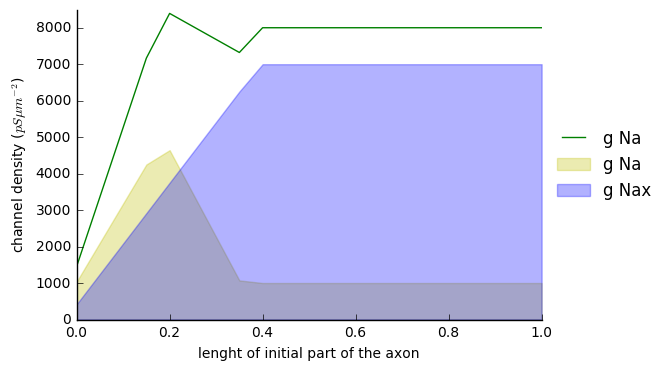

In [22]:
if postfix != 'passive':
    ylim = [0,8500]
    #fig, ax = plt.subplots()
    #ax_ais = plt.subplot(2,2,2)
    ax = plt.subplot(111)
    segments_ais = np.linspace(0,1,21)
    print len(segments_ais), len(na12)
    plt.fill_between(segments_ais, na12, 0, color = 'y', alpha =0.3, label = 'g Na') #segments, na16, alpha=0.3)
    plt.fill_between(segments_ais, na16, 0,color = 'b', alpha=0.3, label = 'g Nax')
    plt.plot(segments_ais, na12+na16, color = 'g', label = 'g Na')

    plt.ylim(ylim)
    plt.xlim(0,1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.ylabel(r'channel density ($pS\mu m^{-2}$)')
    plt.xlabel('lenght of initial part of the axon')
    #ax.set_yticklabels(str_ticks)
    #plt.title('Na distribution in AIS')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon =False)

    
    #ax_soma = plt.subplot(2,2,1)
    #segments_soma = np.linspace(0,1,9)
    #plt.fill_between(segments_soma, na12_soma, 0, color = 'y', alpha =0.3, label = 'g Na1.2')
    #plt.fill_between(segments_soma, na16_soma, 0,color = 'b', alpha=0.3, label = 'g Na1.6')
    #plt.title('soma')
    #plt.ylim(ylim)
    
    #ax_ais = plt.subplot(2,2,4)
    #plt.fill_between(segments_ais, no_Na12_ais, 0, color = 'y', alpha =0.3, label = 'g Na1.2') #segments, na16, alpha=0.3)
    #plt.fill_between(segments_ais, no_Na16_ais, 0,color = 'b', alpha=0.3, label = 'g Na1.6')
    #plt.ylim(ylim)
    #plt.xlim(0,1)
    #plt.title('number of Na channels, AIS')
    #plt.legend()
    
    #ax_soma = plt.subplot(2,2,3)
    #plt.fill_between(segments_soma, no_Na12_soma, 0, color = 'y', alpha =0.3, label = 'g Na1.2')
    #plt.ylim(ylim)    
    
    #pls.clean_plot(ax)
    #ax.stackplot(segments, na12, na16)
    #ax.fill_between(segments, 0, 1, where=na12 > 0, facecolor='green', alpha=0.5)#, transform=trans)
    #plt.savefig('figs/g_Na'+postfix+ext)
    plt.savefig('../../figs/g_Na'+postfix+ext)
    


In [ ]:
if postfix != 'passive':
    print na12_soma, na16_soma
    print seg_coords.dtype.names
    print np.sum(seg_coords[seg_coords['name'] == 'soma']['L'])


    # area of the cylinder without top and buttom
    #A_soma = 
    #A_AIS = L*2.*np.pi*r

In [ ]:
time = (np.arange(len(v_soma))*dt)

#if ramp:
np.savez('../data_hallerman_raw'+postfix+'.npz', I=I, 
         t=time, I_axial=I_axial, v_soma=v_soma,
        i_stim=i_stim,seg_coords=seg_coords,vecs_ais=vecs_ais, 
         v_node=v_node, Na = Na, K=K,
        dt=h.dt, stim_delay = stim_delay)
             #prestim_ms=[prestep_delay_ms,prestep_delay_ms+ramp_len],
             #stim_ms=[ramp_delay_ms,ramp_delay_ms+ramp_len])


In [33]:
#print np.unique(seg_coords['name'])

[seg for seg in seg_coords if seg['name'][:4] == 'node']

[(-3.186422348022461, -182.42300415039062, -0.9700000286102295, -3.1410021781921387, -183.42196655273438, -0.9700000286102295, 1.0, 1.2999999523162842, 'node[0]'),
 (-3.9210023880004883, -216.50196838378906, 5.179999828338623, -3.944575071334839, -217.50169372558594, 5.179999828338623, 1.0, 1.2999999523162842, 'node[1]'),
 (-15.484574317932129, -278.20172119140625, 6.150000095367432, -15.671343803405762, -279.1841125488281, 6.150000095367432, 1.0, 1.2999999523162842, 'node[2]'),
 (-30.89134407043457, -357.91412353515625, -2.700000047683716, -31.081148147583008, -358.89593505859375, -2.700000047683716, 1.0, 1.2999999523162842, 'node[3]'),
 (-45.29114532470703, -441.8159484863281, -16.6299991607666, -45.460052490234375, -442.80157470703125, -16.6299991607666, 1.0, 1.2999999523162842, 'node[4]'),
 (-54.57005310058594, -495.56158447265625, -17.81999969482422, -54.740203857421875, -496.5469970703125, -17.81999969482422, 1.0, 1.2999999523162842, 'node[5]'),
 (-62.990203857421875, -555.067016

In [ ]:

for vec in vecs_ais:
    plt.plot(time, vec, 'k')
plt.plot(time,v_soma, 'r', lw=2)
plt.plot(time, i_stim)

plt.ylim([-100, 40])
plt.xlim([42.5,50])
plt.savefig('../../figs/spike'+postfix+'.pdf')



In [ ]:
#for name in np.unique(seg_coords['name']):
#    print name, len(seg_coords[seg_coords['name'] == name])


## correct I and v_soma, and v_axon

In [ ]:
def correct_data(data_raw, data_pas, prept): #pulse_pt, prepulse_pt):
    # correct the given data: it take the raw data, subtracts data_pas from it and then adds the 
    # value of the data_raw at prept point
    data_pas_corr = data_pas+data_pas[prept]
    data_raw_corr = data_raw+data_raw[prept]
    data = data_raw_corr - data_pas_corr
    data = data + np.array(data_raw[int(dt*(stim_delay-1))])

    return data 

In [ ]:
# correct active data by passive signal

# load raw active data
data_raw = np.load('../data_hallerman_raw'+postfix+'.npz')
I = data_raw['I']
v_soma = data_raw['v_soma']
vecs_ais = data_raw['vecs_ais']
v_node = data_raw['v_node']

# load passive data
if det:
    data_temp = np.load('../data_hallerman_rawpassive_det.npz')
else:
    data_temp = np.load('../data_hallerman_rawpassive.npz')
ais_temp = data_temp['vecs_ais']
I_axial_temp = data_temp['I_axial']
I_temp = data_temp['I']
v_soma_temp = data_temp['v_soma']
v_node_temp = data_temp['v_node']

# get general params (should be the same for both simulations, but no check is being done)
dt = data_temp['dt']
stim_delay = data_temp['stim_delay']
prept = int(dt*(stim_delay-1))

# calculate the new, corrected values of the signal
new_I = correct_data(I, I_temp, prept)
new_v_soma = correct_data(v_soma, v_soma_temp, prept)
new_v_node = correct_data(v_node, v_node_temp,prept)

new_vecs_ais = np.zeros(np.shape(vecs_ais))
for ais_idx in range(len(vecs_ais)):
    new_vecs_ais[ais_idx,:] = correct_data(vecs_ais[ais_idx], ais_temp[ais_idx], prept)

new_I_axial = np.zeros(np.shape(I_axial))
for axial_idx in range(len(I_axial)):
    new_I_axial[axial_idx,:] = correct_data(I_axial[axial_idx], I_axial_temp[axial_idx], prept)

# save the data
if not postfix == 'passive':
    # do not store again corrected passive data
    np.savez('../data_hallerman'+postfix+'.npz', I=new_I, 
             t=time, I_axial=new_I_axial, v_soma=new_v_soma,
            i_stim=i_stim,seg_coords=seg_coords,vecs_ais=new_vecs_ais, 
             v_node=v_node_temp, Na = Na, K=K,
            dt=h.dt, stim_delay = stim_delay)

In [ ]:
plt.subplot(3,2,1)
plt.plot(time, v_soma_temp.T, color = 'b', label='pas')
plt.plot(time, v_soma.T, color = 'g', label='old')
plt.plot(time, new_v_soma.T, color = 'r', label = 'new')
plt.title('v soma')

plt.subplot(3,2,2)
plt.plot(time, ais_temp.T, color = 'b', label='pas')
plt.plot(time, vecs_ais.T, color = 'g', label='old')
plt.plot(time, new_vecs_ais.T, color = 'r', label = 'new')
plt.title('v ais')

plt.subplot(3,2,3)
plt.plot(I_temp[:,0], color = 'b',label='pas')
plt.plot(I[:,0], color = 'g', label='old')
plt.plot(new_I[:,0], color = 'r',label = 'new')
plt.title('I')
print np.unique(I_temp)


plt.subplot(3,2,4)
plt.plot(I_axial_temp[:,0], color = 'b',label='pas')
plt.plot(I_axial[:,0], color = 'g', label='old')
plt.plot(new_I_axial[:,0], color = 'r',label = 'new')
plt.title('I axial soma')

plt.subplot(3,2,5)
plt.plot(time, v_node_temp, color = 'b', label='pas')
plt.plot(time, v_node, color = 'g', label='old')
plt.plot(time, new_v_node, color = 'r',label = 'new')
plt.title('v node')

plt.subplot(3,2,6)
plt.plot(time, v_node_temp, color = 'b', label='pas')
plt.plot(time, v_node, color = 'g', label='old')
plt.plot(time, new_v_node, color = 'r',label = 'new')
plt.title('temp')
plt.legend()

plt.savefig('../../figs/corrected_signals'+postfix+'.pdf')



In [ ]:
plt.plot(I_temp[:,0], color = 'b',label='pas')
plt.plot(I[:,0], color = 'g', label='old')
plt.plot(new_I[:,0], color = 'r',label = 'new')
plt.title('I')
plt.xlim([4000, 5000])
print np.unique(I_temp[:,0])

In [ ]:
'''  
np.savez('../data_hallerman'+postfix+'.npz', I=I_corr, t=t_corr, I_axial=I_axial_corr, v_soma=v_soma_corr,
        seg_coords=seg_coords,vecs_ais=vecs_ais_corr, v_node=v_node_corr, Na = Na, K=K,
        dt=h.dt, 
             prestim_ms=[prestep_delay_ms,prestep_delay_ms+ramp_len],
             stim_ms=[ramp_delay_ms,ramp_delay_ms+ramp_len])
             '''  

In [ ]:
#%pwd

In [ ]:
plt.plot(I_temp[:,0], color = 'b',label='pas')